## W1-pOEx workflow


Activating silent BGCs is a highly sought-after endeavor, and our goal was to develop a method for overexpressing regulators.


 This approach has proven effective in activating silent BGCs and enhancing the yields of natural products in streptomyces23–25. To achieve this, we sought a rapid and standardized workflow for overexpressing regulators and devised a plasmid system called pOEX-PkasO (Figure 2A). This system is based on the integrative plasmid pRM4,  described by Menges et. al 200726, but incorporates one of the strongest known promoters engineered in Streptomyces namely PkasO27 along with the canonical RBS sequence “GGAGG”28. The system was experimentally verified and the results can be found in the section “Example usage of workflow 1”. 



In [1]:
import sys
import os

# Ensure the src directory is in the Python path
# Assuming your notebooks are in a subdirectory of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importing necessary libraries
from Bio.Restriction import StuI
from datetime import datetime


# Importing from custom modules
from streptocad.primers.primer_analysis import analyze_primers_and_hairpins
from streptocad.cloning.plasmid_processing import assemble_and_process_plasmids
from streptocad.cloning.pcr_simulation import perform_pcr_on_sequences
from streptocad.sequence_loading.sequence_loading import load_and_process_plasmid, load_and_process_genome_sequences
from streptocad.utils import polymerase_dict, extract_metadata_to_dataframe, ProjectDirectory
from streptocad.primers.primer_generation import generate_primer_dataframe, create_idt_order_dataframe


In [2]:
from pydna.dseqrecord import Dseqrecord
from Bio.SeqFeature import SeqFeature


def extract_cds_records(record: Dseqrecord, max_records: int = None):
    """
    Iterate through a Dseqrecord, extract each CDS feature's nucleotide sequence,
    and return a list of new Dseqrecord objects for CDS features only,
    stopping after `max_records` if specified.

    :param record: pydna.dseqrecord.Dseqrecord object
    :param max_records: maximum number of CDS feature records to create (None for no limit)
    :return: list of pydna.dseqrecord.Dseqrecord objects for CDS features
    """
    cds_records = []
    count = 0

    if not hasattr(record, 'features'):
        return cds_records

    for feature in record.features:
        # Filter for CDS features only
        if feature.type != 'CDS':
            continue

        # Stop if reached max_records
        if max_records is not None and count >= max_records:
            break

        # Extract the sequence; feature.location is used internally
        try:
            seq = feature.extract(record.seq)
        except Exception:
            continue

        # Determine identifier: use locus_tag if available
        qualifiers = getattr(feature, 'qualifiers', {})
        locus_tags = qualifiers.get('locus_tag', [])
        identifier = locus_tags[0] if locus_tags else (getattr(feature, 'id', None) or feature.type)

        # Create a new Dseqrecord for the CDS feature
        cds_record = Dseqrecord(seq, id=str(identifier), description=f"CDS feature {identifier}")
        cds_records.append(cds_record)
        count += 1

        if max_records is not None and count >= max_records:
            break

    return cds_records



# Inputs


In [3]:
# Inputs
# 1 files to incorporate into the pOEX-PKasO (genbank, fasta)
path_to_genome = '../../../../data/genomes/Streptomyces_coelicolor_A3_chromosome.gb'
genome = load_and_process_genome_sequences(path_to_genome)[0]
clean_seq = extract_cds_records(genome, max_records=10)

# 2 Add plasmid 
path_to_plasmid = '../../../../data/plasmids/pOEX-PkasO.gb'
clean_plasmid = load_and_process_plasmid(path_to_plasmid)

# 3 Choose overlapping sequences for our plasmid we can use the following
up_homology = "GGCGAGCAACGGAGGTACGGACAGG".upper()
dw_homology = "CGCAAGCCGCCACTCGAACGGAAGG".upper()

#### Advanced settings ####
# 4 Choose polymerase and target melting temperature
chosen_polymerase = 'Q5 High-Fidelity 2X Master Mix'
melting_temperature = 60
primer_concentration = 0.4 
primer_number_increment = 1

/Users/lucaslevassor/opt/anaconda3/envs/streptocad/lib/python3.11/site-packages/Bio/GenBank/Scanner.py:1529: BiopythonParserWarning: Attempting to parse malformed locus line:
'LOCUS       pOEX-PkasO        5230 bp DNA     circular SYN 06-DEC-2023\n'
Found locus 'pOEX-PkasO' size '5230' residue_type 'DNA'
Some fields may be wrong.
  warnings.warn(


In [4]:
clean_seq

[Dseqrecord(-678),
 Dseqrecord(-2562),
 Dseqrecord(-2352),
 Dseqrecord(-948),
 Dseqrecord(-2121),
 Dseqrecord(-1107),
 Dseqrecord(-447),
 Dseqrecord(-351),
 Dseqrecord(-336),
 Dseqrecord(-1092)]

# Outputs

In [5]:
# 1 Table with overview of primers and their analysis
primer_df = generate_primer_dataframe(clean_seq, 
                                      melting_temperature, 
                                      polymerase_dict[chosen_polymerase], 
                                      primer_concentration,
                                      up_homology, dw_homology)
primer_df

/Users/lucaslevassor/opt/anaconda3/envs/streptocad/lib/python3.11/site-packages/pydna/design.py:189: _PydnaWarning: designed primers do not yield a unique PCR product
  _warnings.warn(


,template,f_primer_anneal(5-3),r_primer_anneal(5-3),f_tm,r_tm,ta,f_primer_sequences(5-3),r_primer_sequences(5-3),f_primer_name,r_primer_name
0,SCO0001,ATGACCGGTCACCAC,CTATTTCCGTGGTCCTTC,61,59,60,GGCGAGCAACGGAGGTACGGACAGGATGACCGGTCACCAC,CGCAAGCCGCCACTCGAACGGAAGGCTATTTCCGTGGTCCTTC,primer_fwd_SCO0001,primer_rev_SCO0001
1,SCO0002,ATGGGGGTGTCCG,CTACGCCGCCCAT,60,61,61,GGCGAGCAACGGAGGTACGGACAGGATGGGGGTGTCCG,CGCAAGCCGCCACTCGAACGGAAGGCTACGCCGCCCAT,primer_fwd_SCO0002,primer_rev_SCO0002
2,SCO0003,GTGACGGATCCGTTTTCC,TCAGACCGGGAGATCC,63,62,63,GGCGAGCAACGGAGGTACGGACAGGGTGACGGATCCGTTTTCC,CGCAAGCCGCCACTCGAACGGAAGGTCAGACCGGGAGATCC,primer_fwd_SCO0003,primer_rev_SCO0003
3,SCO0004,GTGCGGCACGGTAT,TTACCGTGGGTGCC,62,61,62,GGCGAGCAACGGAGGTACGGACAGGGTGCGGCACGGTAT,CGCAAGCCGCCACTCGAACGGAAGGTTACCGTGGGTGCC,primer_fwd_SCO0004,primer_rev_SCO0004
4,SCO0005,GTGGTGGAGGTCGG,TCACCATTGCTCGGCT,61,64,62,GGCGAGCAACGGAGGTACGGACAGGGTGGTGGAGGTCGG,CGCAAGCCGCCACTCGAACGGAAGGTCACCATTGCTCGGCT,primer_fwd_SCO0005,primer_rev_SCO0005
5,SCO0006,GTGAACGCCTCACCG,TCACGGGGTGCTG,63,60,62,GGCGAGCAACGGAGGTACGGACAGGGTGAACGCCTCACCG,CGCAAGCCGCCACTCGAACGGAAGGTCACGGGGTGCTG,primer_fwd_SCO0006,primer_rev_SCO0006
6,SCO0007,GTGTGCGTGGTGCG,TCATACGGGCAACGG,64,61,62,GGCGAGCAACGGAGGTACGGACAGGGTGTGCGTGGTGCG,CGCAAGCCGCCACTCGAACGGAAGGTCATACGGGCAACGG,primer_fwd_SCO0007,primer_rev_SCO0007
7,SCO0008,GTGGCGTGTGTGGG,CTACGGCACCCACG,63,62,63,GGCGAGCAACGGAGGTACGGACAGGGTGGCGTGTGTGGG,CGCAAGCCGCCACTCGAACGGAAGGCTACGGCACCCACG,primer_fwd_SCO0008,primer_rev_SCO0008
8,SCO0009,TTGTGCGGCCGC,TCACAGCAGCGGGA,63,63,64,GGCGAGCAACGGAGGTACGGACAGGTTGTGCGGCCGC,CGCAAGCCGCCACTCGAACGGAAGGTCACAGCAGCGGGA,primer_fwd_SCO0009,primer_rev_SCO0009
9,SCO0010,GTGACGGGCCGC,TCACTGTCGCCCACG,63,65,64,GGCGAGCAACGGAGGTACGGACAGGGTGACGGGCCGC,CGCAAGCCGCCACTCGAACGGAAGGTCACTGTCGCCCACG,primer_fwd_SCO0010,primer_rev_SCO0010


## Simulating the PCRs

In [6]:
list_of_amplicons = perform_pcr_on_sequences(primer_df, 
                                             clean_seq)

SCO0001_amplicon , Length: 728
                         5ATGACCGGTCACCAC...GAAGGACCACGGAAATAG3
                                            ||||||||||||||||||
                                           3CTTCCTGGTGCCTTTATCGGAAGGCAAGCTCACCGCCGAACGC5
5GGCGAGCAACGGAGGTACGGACAGGATGACCGGTCACCAC3
                          |||||||||||||||
                         3TACTGGCCAGTGGTG...CTTCCTGGTGCCTTTATC5

SCO0002_amplicon , Length: 2612
                         5ATGGGGGTGTCCG...ATGGGCGGCGTAG3
                                          |||||||||||||
                                         3TACCCGCCGCATCGGAAGGCAAGCTCACCGCCGAACGC5
5GGCGAGCAACGGAGGTACGGACAGGATGGGGGTGTCCG3
                          |||||||||||||
                         3TACCCCCACAGGC...TACCCGCCGCATC5

SCO0003_amplicon , Length: 2402
                         5GTGACGGATCCGTTTTCC...GGATCTCCCGGTCTGA3
                                               ||||||||||||||||
                                              3CCTAGAGGGCCAGACTGGAAGGCAAGCTC

In [7]:
list_of_amplicons[0].figure()

                         5ATGACCGGTCACCAC...GAAGGACCACGGAAATAG3
                                            ||||||||||||||||||
                                           3CTTCCTGGTGCCTTTATCGGAAGGCAAGCTCACCGCCGAACGC5
5GGCGAGCAACGGAGGTACGGACAGGATGACCGGTCACCAC3
                          |||||||||||||||
                         3TACTGGCCAGTGGTG...CTTCCTGGTGCCTTTATC5

In [8]:
# 2 Ready made IDT format
idt_df = create_idt_order_dataframe(primer_df, concentration="25nm", purification="STD")
idt_df

,Name,Sequence,Concentration,Purification
0,primer_fwd_SCO0001,GGCGAGCAACGGAGGTACGGACAGGATGACCGGTCACCAC,25nm,STD
1,primer_fwd_SCO0002,GGCGAGCAACGGAGGTACGGACAGGATGGGGGTGTCCG,25nm,STD
2,primer_fwd_SCO0003,GGCGAGCAACGGAGGTACGGACAGGGTGACGGATCCGTTTTCC,25nm,STD
3,primer_fwd_SCO0004,GGCGAGCAACGGAGGTACGGACAGGGTGCGGCACGGTAT,25nm,STD
4,primer_fwd_SCO0005,GGCGAGCAACGGAGGTACGGACAGGGTGGTGGAGGTCGG,25nm,STD
5,primer_fwd_SCO0006,GGCGAGCAACGGAGGTACGGACAGGGTGAACGCCTCACCG,25nm,STD
6,primer_fwd_SCO0007,GGCGAGCAACGGAGGTACGGACAGGGTGTGCGTGGTGCG,25nm,STD
7,primer_fwd_SCO0008,GGCGAGCAACGGAGGTACGGACAGGGTGGCGTGTGTGGG,25nm,STD
8,primer_fwd_SCO0009,GGCGAGCAACGGAGGTACGGACAGGTTGTGCGGCCGC,25nm,STD
9,primer_fwd_SCO0010,GGCGAGCAACGGAGGTACGGACAGGGTGACGGGCCGC,25nm,STD


In [9]:
# 3 analyzed primers
analyzed_primers = analyze_primers_and_hairpins(primer_df)
analyzed_primers

,annealing_temperature,primer_pair,homodimer_forward_tm,homodimer_forward_deltaG (kcal/mol),homodimer_reverse_tm,homodimer_reverse_deltaG (kcal/mol),heterodimer_tm,heterodimer_deltaG (kcal/mol),hairpin_forward_structure_found,hairpin_forward_tm,hairpin_forward_deltaG (kcal/mol),hairpin_reverse_structure_found,hairpin_reverse_tm,hairpin_reverse_deltaG (kcal/mol),f_tm,r_tm
0,60,primer_fwd_SCO0001 & primer_rev_SCO0001,36.359824,-2.225027,29.686311,-0.455925,20.213570,-0.248342,True,68.087965,-0.872227,True,65.536773,-0.717667,61,59
1,61,primer_fwd_SCO0002 & primer_rev_SCO0002,31.250938,-2.115135,28.877547,5.571521,18.915615,0.308351,True,65.793408,-0.722667,True,55.527912,0.396241,60,61
2,63,primer_fwd_SCO0003 & primer_rev_SCO0003,38.363089,-5.813057,14.316611,-1.215689,25.326339,1.564200,True,55.774876,0.700711,False,0.000000,0.000000,63,62
3,62,primer_fwd_SCO0004 & primer_rev_SCO0004,25.240065,-2.609148,17.940821,4.136200,27.114899,3.924864,True,59.896964,0.111767,True,58.363152,0.357637,62,61
4,62,primer_fwd_SCO0005 & primer_rev_SCO0005,-2.732299,-1.491319,17.052331,1.510040,39.344688,-2.499228,False,0.000000,0.000000,False,0.000000,0.000000,61,64
5,62,primer_fwd_SCO0006 & primer_rev_SCO0006,27.572334,4.961156,17.052331,1.510040,16.034890,-1.661022,True,64.561503,-0.292018,False,0.000000,0.000000,63,60
6,62,primer_fwd_SCO0007 & primer_rev_SCO0007,29.298452,-1.826461,17.052331,1.510040,16.034890,-1.661022,True,63.752133,-0.195027,False,0.000000,0.000000,64,61
7,63,primer_fwd_SCO0008 & primer_rev_SCO0008,-2.732299,-1.363291,28.649675,6.442004,38.004152,-5.761424,False,0.000000,0.000000,False,0.000000,0.000000,63,62
8,64,primer_fwd_SCO0009 & primer_rev_SCO0009,42.349535,-6.963009,22.537822,7.046502,16.195424,-3.633864,True,60.045291,0.407108,False,0.000000,0.000000,63,63
9,64,primer_fwd_SCO0010 & primer_rev_SCO0010,28.714106,-4.944682,17.052331,2.044189,22.361255,-2.666951,False,0.000000,0.000000,False,0.000000,0.000000,63,65


SCO0001_amplicon
SCO0002_amplicon
SCO0003_amplicon
SCO0004_amplicon
SCO0005_amplicon
SCO0006_amplicon
SCO0007_amplicon
SCO0008_amplicon


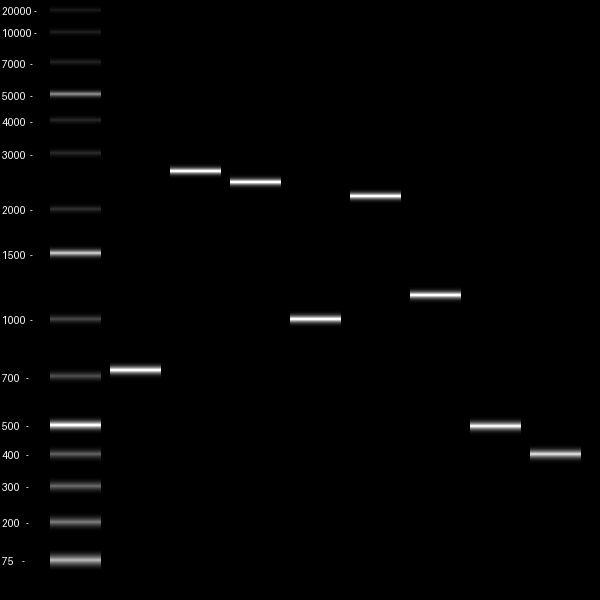

In [10]:
from pydna.gel import gel
from pydna.ladders import GeneRuler_1kb_plus

bands = list_of_amplicons
for band in bands:
    print(band.name)

gel([GeneRuler_1kb_plus, *[[band] for band in bands]])

In [11]:
# 3 Assembled plasmid genbank files
assembled_plasmids, assembly_results = assemble_and_process_plasmids(clean_plasmid, list_of_amplicons, 
                              enzymes=[StuI], 
                              save_plasmids=False, 
                              save_path="../../data/plasmids/pOEX_overexpression_plasmids")

########### ENZYMMMMMEEES [StuI]
########### ENZYMMMMMEEES [StuI]


In [12]:
assembly_results

[Contig(o5908),
 Contig(o7792),
 Contig(o7582),
 Contig(o6178),
 Contig(o7351),
 Contig(o6337),
 Contig(o5677),
 Contig(o5581)]

In [13]:
assembled_plasmids

[Dseqrecord(o5908),
 Dseqrecord(o7792),
 Dseqrecord(o7582),
 Dseqrecord(o6178),
 Dseqrecord(o7351),
 Dseqrecord(o6337),
 Dseqrecord(o5677),
 Dseqrecord(o5581)]

In [14]:


amplicon_names = [seq.name for seq in list_of_amplicons]
plasmid_metadata_df = extract_metadata_to_dataframe(assembled_plasmids,
                                                    clean_plasmid,
                                                    amplicon_names)

plasmid_metadata_df

,plasmid_name,date,original_plasmid,integration,size
0,pOEx-KasO_SCO0001_amplicon,2025-05-12,pOEX-PkasO,SCO0001_amplicon,5908
1,pOEx-KasO_SCO0002_amplicon,2025-05-12,pOEX-PkasO,SCO0002_amplicon,7792
2,pOEx-KasO_SCO0003_amplicon,2025-05-12,pOEX-PkasO,SCO0003_amplicon,7582
3,pOEx-KasO_SCO0004_amplicon,2025-05-12,pOEX-PkasO,SCO0004_amplicon,6178
4,pOEx-KasO_SCO0005_amplicon,2025-05-12,pOEX-PkasO,SCO0005_amplicon,7351
5,pOEx-KasO_SCO0006_amplicon,2025-05-12,pOEX-PkasO,SCO0006_amplicon,6337
6,pOEx-KasO_SCO0007_amplicon,2025-05-12,pOEX-PkasO,SCO0007_amplicon,5677
7,pOEx-KasO_SCO0008_amplicon,2025-05-12,pOEX-PkasO,SCO0008_amplicon,5581


## Folder with all the generated I/O

In [15]:


input_files = [
    {"name": "input_sequences.gb", "content": clean_seq},
    {"name": "input_plasmid.gb", "content": clean_plasmid}
]

output_files = [
    {"name": "pOEX-PKasO.gb", "content": assembled_plasmids}, # LIST OF Dseqrecords
    {"name": "primer_df.csv", "content": primer_df},
    {"name": "full_idt.csv", "content": idt_df},
    {"name": "primers_analyzed.csv", "content": analyzed_primers},
    {"name": "plasmid_metadata_df.csv", "content": plasmid_metadata_df},

]

input_values = {
    "polymerase_settings": {
        "chosen_polymerase": chosen_polymerase,
        "melting_temperature": melting_temperature,
        "primer_concentration": primer_concentration,
        "primer_number_increment": primer_number_increment,
    },

    "overlapping_sequences": {
        "up_homology": str(up_homology),
        "dw_homology": str(dw_homology)
    }
}

# Paths to Markdown files
markdown_file_paths = [
    "../../protocols/conjugation_protcol.md",
    "../../overexpression_protocol.md",
]

# Data and time
timestamp = datetime.utcnow().isoformat()

project_name=f"pOEX-PKasO_workflow_{timestamp}"
# Create project directory structure
project_directory = ProjectDirectory(
    project_name=project_name,
    input_files=input_files,
    output_files=output_files,
    input_values=input_values,
    markdown_file_paths=markdown_file_paths
)


# DO You want to save the folder? 
save_zip_folder = False 

if save_zip_folder: 
    # Generate the project directory structure and get the zip content
    zip_content = project_directory.create_directory_structure(create_directories=False)

    # Save the zip file to disk (optional)
    with open("project_structure.zip", "wb") as f:
        f.write(zip_content)